<a href="https://colab.research.google.com/github/mequanent/Music-Recommendation-Exercises/blob/main/App%20Recommendation%20using%20LightGCN%20via%20Pytorch%20Geometric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# To install the correct version of Pytorch Geometric.
# This cell is modified from: https://gist.github.com/ameya98/b193856171d11d37ada46458f60e73e7

import torch

TORCH_version = torch.__version__
CUDA_version = torch.version.cuda

TORCH = TORCH_version.split('+')[0]
CUDA = 'cu' + CUDA_version.replace('.', '')

!pip install -q torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-geometric 

     |████████████████████████████████| 7.9 MB 5.1 MB/s 
     |████████████████████████████████| 3.5 MB 5.2 MB/s 
     |████████████████████████████████| 2.5 MB 5.1 MB/s 
     |████████████████████████████████| 750 kB 4.9 MB/s 
     |████████████████████████████████| 407 kB 5.1 MB/s 


**References**: 

LightGCN with PyTorch Geometric from [Medium](https://medium.com/stanford-cs224w/lightgcn-with-pytorch-geometric-91bab836471e).(hhotta@stanford.edu)

https://www.kaggle.com/dipanjandas96/lightgcn-pytorch-from-scratch

In [ ]:
# Libraries
from pathlib import Path
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as prep

import torch
from torch import nn, optim, Tensor
from torch_sparse import SparseTensor, matmul

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj

# Loading the Dataset

In [ ]:
#url = 'http://jmcauley.ucsd.edu/data/amazon/qa/icdm/QA_Baby.json.gz'
meta_url = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Apps_for_Android.json.gz'
rating_url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Apps_for_Android.csv"
review_url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Apps_for_Android_5.json.gz"

In [ ]:
review = pd.read_json(review_url, lines = True)
rename_col_dicts = {'reviewerID': 'userId', 'asin': 'appId', 'reviewerName': 'userName', 
                    'overall': 'rating', 'unixReviewTime': 'timestamp'}
review.rename(columns = rename_col_dicts, inplace = True)
review[:2]

,userId,appId,userName,helpful,reviewText,rating,summary,timestamp,reviewTime
0,A1N4O8VOJZTDVB,B004A9SDD8,Annette Yancey,"[1, 1]","Loves the song, so he really couldn't wait to ...",3,Really cute,1383350400,"11 2, 2013"
1,A2HQWU6HUKIEC7,B004A9SDD8,"Audiobook lover ""Kathy""","[0, 0]","Oh, how my little grandson loves this app. He'...",5,2-year-old loves it,1323043200,"12 5, 2011"


In [ ]:
reviews = review[['userId', 'appId', 'rating',  'timestamp', 'userName']]
reviews = reviews.copy()
reviews['title'] = reviews['appId'].tolist() # Use the appId as title since not title
reviews[:2]

,userId,appId,rating,timestamp,userName,title
0,A1N4O8VOJZTDVB,B004A9SDD8,3,1383350400,Annette Yancey,B004A9SDD8
1,A2HQWU6HUKIEC7,B004A9SDD8,5,1323043200,"Audiobook lover ""Kathy""",B004A9SDD8


In [ ]:
a = reviews['userId'].value_counts().index.tolist()[:1400]
ratings = reviews.loc[reviews['userId'].isin(a)]
print(len(ratings['userId'].value_counts()), len(ratings['appId'].value_counts()))
b = ratings['appId'].value_counts().index.tolist()[:10000]
ratings = ratings.loc[ratings['appId'].isin(b)]

1400 10028


In [ ]:
print(len(reviews['userId'].value_counts()), len(reviews['appId'].value_counts()))
print(len(ratings['userId'].value_counts()), len(ratings['appId'].value_counts()))
print(reviews.shape)
print(ratings.shape)

87271 13209
1400 10000
(752937, 6)
(69556, 6)


+----------+---------+
|   Rating |   Count |
|----------+---------|
|        5 |   30341 |
|        4 |   14501 |
|        3 |   10344 |
|        1 |    8453 |
|        2 |    5917 |
+----------+---------+


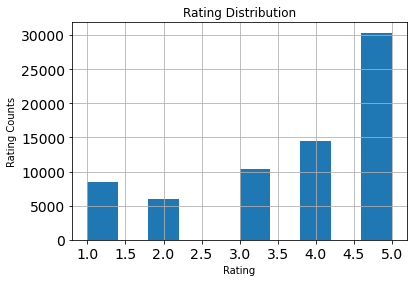

In [ ]:
from tabulate import tabulate

z = pd.DataFrame(ratings['rating'].value_counts())
columns = ['Rating', 'Count']
print(tabulate(z, headers=columns, tablefmt='psql'))

ratings['rating'].hist(xlabelsize=14, ylabelsize=14)
plt.xlabel('Rating')
plt.ylabel('Rating Counts')
plt.title('Rating Distribution')
plt.show()

In [ ]:
leu = prep.LabelEncoder() # ['userId','appId','rating','timestamp']
lem = prep.LabelEncoder()

ratings['appId'] = leu.fit_transform(ratings['appId'].values)
ratings['userId'] = lem.fit_transform(ratings['userId'].values)
print(ratings.shape)
ratings.head(2)

(69556, 6)


,userId,appId,rating,timestamp,userName,title
31,1252,0,4,1385164800,C. Riostirado,B004AFQAUA
71,386,0,4,1356739200,"S. Majocha ""Nursee13""",B004AFQAUA


In [ ]:
rating = ratings[['userId', 'userName', 'appId',	'rating',	'timestamp']]
app = ratings[['appId', 'title']].drop_duplicates()
app.shape

(10000, 2)

In [ ]:
print(len(ratings.userId.value_counts()), len(app.appId.value_counts()))

1400 10000


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = Path('/content/drive/MyDrive/Colab Notebooks/AppRecSys/') 
app_path = path/'app.csv'
rating_path = path/'rating.csv'

app.to_csv(app_path, index=False)
rating.to_csv(rating_path, index=False)

In [ ]:
r = pd.read_csv(rating_path)
r.shape

(69556, 5)

In [ ]:
# load user and app nodes
def load_node_csv(path, index_col):
    df = pd.read_csv(path, index_col=index_col)
    mapping = {index: i for i, index in enumerate(df.index.unique())}
    return mapping

user_mapping = load_node_csv(rating_path, index_col='userId')
app_mapping = load_node_csv(app_path, index_col='appId')

In [ ]:
# load edges between users and apps
def load_edge_csv(path, src_index_col, src_mapping, dst_index_col, dst_mapping, link_index_col, rating_threshold=4):
    #Loads csv containing edges between users and items

    df = pd.read_csv(path)
    edge_index = None
    src = [src_mapping[index] for index in df[src_index_col]] # mapping between row number and user id
    dst = [dst_mapping[index] for index in df[dst_index_col]] # mapping between row number and item id
    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold

    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])

    return torch.tensor(edge_index)

edge_index = load_edge_csv(
    rating_path,
    src_index_col='userId',
    src_mapping=user_mapping,
    dst_index_col='appId',
    dst_mapping=app_mapping,
    link_index_col='rating',
    rating_threshold=4,
)

In [ ]:
# 80/10/10  train/validation/test split of edges in the graph
num_users, num_apps = len(user_mapping), len(app_mapping)
num_interactions = edge_index.shape[1]
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(
    all_indices, test_size=0.2, random_state=1)
val_indices, test_indices = train_test_split(
    test_indices, test_size=0.5, random_state=1)

train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

In [ ]:
# convert edge indices into Sparse Tensors: https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
train_sparse_edge_index = SparseTensor(row=train_edge_index[0], col=train_edge_index[1], sparse_sizes=(
    num_users + num_apps, num_users + num_apps))
val_sparse_edge_index = SparseTensor(row=val_edge_index[0], col=val_edge_index[1], sparse_sizes=(
    num_users + num_apps, num_users + num_apps))
test_sparse_edge_index = SparseTensor(row=test_edge_index[0], col=test_edge_index[1], sparse_sizes=(
    num_users + num_apps, num_users + num_apps)) 

In [ ]:
# function which random samples a mini-batch of positive and negative samples
def sample_mini_batch(batch_size, edge_index):
    edges = structured_negative_sampling(edge_index)
    edges = torch.stack(edges, dim=0)
    indices = random.choices(
        [i for i in range(edges[0].shape[0])], k=batch_size)
    batch = edges[:, indices]
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices # 3 tuples

In [ ]:
# defines LightGCN model
class LightGCN(MessagePassing):
    def __init__(self, num_users, num_items, embedding_dim=64, K=2, add_self_loops=False):
        super().__init__()
        self.num_users, self.num_items = num_users, num_items
        self.embedding_dim, self.K = embedding_dim, K
        self.add_self_loops = add_self_loops

        self.users_emb = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
        self.items_emb = nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0

        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index: SparseTensor):

        # compute \tilde{A}: symmetrically normalized adjacency matrix
        edge_index_norm = gcn_norm(
            edge_index, add_self_loops=self.add_self_loops)

        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0
        embs = [emb_0]
        emb_k = emb_0

        # multi-scale diffusion
        for i in range(self.K):
            emb_k = self.propagate(edge_index_norm, x=emb_k)
            embs.append(emb_k)

        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1) # E^K

        users_emb_final, items_emb_final = torch.split(
            emb_final, [self.num_users, self.num_items]) # splits into e_u^K and e_i^K

        # returns e_u^K, e_u^0, e_i^K, e_i^0
        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        # computes \tilde{A} @ x
        return matmul(adj_t, x)

model = LightGCN(num_users, num_apps)

In [ ]:
def bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_val):

    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2)) # L2 loss

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # predicted scores of negative samples

    loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) + reg_loss

    return loss

In [ ]:
# helper function to get N_u
def get_user_positive_items(edge_index):
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_pos_items:
            user_pos_items[user] = []
        user_pos_items[user].append(item)
    return user_pos_items

In [ ]:
# computes recall@K and precision@K
def RecallPrecision_ATk(groundTruth, r, k):

    num_correct_pred = torch.sum(r, dim=-1)  # number of correctly predicted items per user
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i])
                                  for i in range(len(groundTruth))])
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

In [ ]:
# computes NDCG@K
def NDCGatK_r(groundTruth, r, k):
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

In [ ]:
# wrapper function to get evaluation metrics
def get_metrics(model, edge_index, exclude_edge_indices, k):
    user_embedding = model.users_emb.weight
    item_embedding = model.items_emb.weight

    # get ratings between every user and item - shape is num users x num apps
    rating = torch.matmul(user_embedding, item_embedding.T)

    for exclude_edge_index in exclude_edge_indices:
        # gets all the positive items for each user from the edge index
        user_pos_items = get_user_positive_items(exclude_edge_index)
        # get coordinates of all edges to exclude
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)

        # set ratings of excluded edges to large negative value
        rating[exclude_users, exclude_items] = -(1 << 10)

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(rating, k=k)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_positive_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [
        test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    r = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        r.append(label)
    r = torch.Tensor(np.array(r).astype('float'))

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [ ]:
# wrapper function to evaluate model
def evaluation(model, edge_index, sparse_edge_index, exclude_edge_indices, k, lambda_val):
    # get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        sparse_edge_index)
    edges = structured_negative_sampling(
        edge_index, contains_neg_self_loops=False)
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]
    #print("items_emb_final", items_emb_final)
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]

    loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0,
                    neg_items_emb_final, neg_items_emb_0, lambda_val).item()

    recall, precision, ndcg = get_metrics(
        model, edge_index, exclude_edge_indices, k)

    return loss, recall, precision, ndcg

In [ ]:
# define constants
ITERATIONS = 10000
BATCH_SIZE = 1024
LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 20
LAMBDA = 1e-6

In [ ]:
# setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")

model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)

val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = val_sparse_edge_index.to(device)

Using device cpu.


In [ ]:
# training loop
train_losses = []
val_losses = []

neg_items_emb_final2 = neg_items_emb_02 = items_emb_final2 = items_emb_02 = neg_item_indices2 = []

for iter in range(ITERATIONS):
    # forward propagation
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        train_sparse_edge_index)

    # mini batching
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(
        BATCH_SIZE, train_edge_index)
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(
        device), pos_item_indices.to(device), neg_item_indices.to(device)
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]

    items_emb_final2, items_emb_02, neg_item_indices2 = items_emb_final, items_emb_0, neg_item_indices 
    
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]
    
    neg_items_emb_final2, neg_items_emb_02 = neg_items_emb_final, neg_items_emb_0
    # loss computation
    train_loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final,
                          pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, LAMBDA)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        val_loss, recall, precision, ndcg = evaluation(
            model, val_edge_index, val_sparse_edge_index, [train_edge_index], K, LAMBDA)
        print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}")
        train_losses.append(train_loss.item())
        val_losses.append(val_loss)
        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

[Iteration 0/10000] train_loss: -0.69109, val_loss: -0.68476, val_recall@20: 0.0014, val_precision@20: 0.00027, val_ndcg@20: 0.00065
[Iteration 200/10000] train_loss: -0.69617, val_loss: -0.68483, val_recall@20: 0.00227, val_precision@20: 0.00039, val_ndcg@20: 0.00094
[Iteration 400/10000] train_loss: -0.70542, val_loss: -0.6857, val_recall@20: 0.01521, val_precision@20: 0.00278, val_ndcg@20: 0.00926
[Iteration 600/10000] train_loss: -0.73981, val_loss: -0.70482, val_recall@20: 0.06745, val_precision@20: 0.01096, val_ndcg@20: 0.03594
[Iteration 800/10000] train_loss: -0.9017, val_loss: -0.81886, val_recall@20: 0.07797, val_precision@20: 0.01214, val_ndcg@20: 0.04229
[Iteration 1000/10000] train_loss: -1.36337, val_loss: -1.19276, val_recall@20: 0.07799, val_precision@20: 0.01222, val_ndcg@20: 0.04313
[Iteration 1200/10000] train_loss: -2.18307, val_loss: -1.934, val_recall@20: 0.07897, val_precision@20: 0.01237, val_ndcg@20: 0.04381
[Iteration 1400/10000] train_loss: -3.48928, val_loss

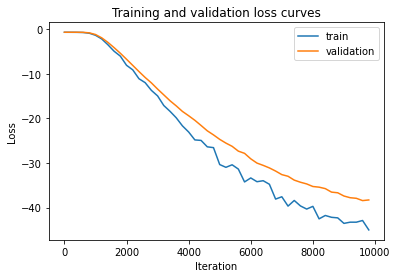

In [ ]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and validation loss curves')
plt.legend()
plt.show()

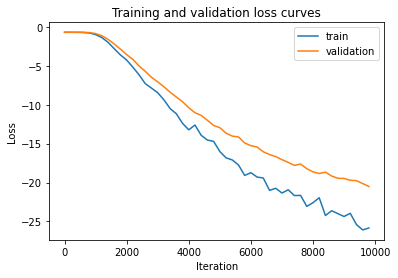

In [ ]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and validation loss curves')
plt.legend()
plt.show()

Test set performance should be in line with the following (*K=20*):

*Recall@K: 0.13, Precision@K: 0.045, NDCG@K: 0.10*

In [ ]:
# K = 2
# evaluate on test set
model.eval()
test_edge_index = test_edge_index.to(device)
test_sparse_edge_index = test_sparse_edge_index.to(device)

test_loss, test_recall, test_precision, test_ndcg = evaluation(
            model, test_edge_index, test_sparse_edge_index, [train_edge_index, val_edge_index], K, LAMBDA)

print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}]")

[test_loss: -40.73944, test_recall@20: 0.0656, test_precision@20: 0.01088, test_ndcg@20: 0.03676]


In [ ]:
# K = 3
# Evaluate on test set
model.eval()
test_edge_index = test_edge_index.to(device)
test_sparse_edge_index = test_sparse_edge_index.to(device)

test_loss, test_recall, test_precision, test_ndcg = evaluation(
            model, test_edge_index, test_sparse_edge_index, [train_edge_index, val_edge_index], K, LAMBDA)

print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}")

[test_loss: -21.63686, test_recall@20: 0.06651, test_precision@20: 0.01108, test_ndcg@20: 0.03656


# Make New Recommendatios for a Given User

In [ ]:
model.eval()
df = pd.read_csv(app_path)
appid_title = pd.Series(df.title.values,index=df.appId).to_dict()

user_pos_items = get_user_positive_items(edge_index)

In [ ]:
df2 = pd.read_csv(rating_path) # 336
counts = df2.userId.value_counts().to_dict()#[336]
#counts

In [ ]:
def make_predictions(user_id, num_recs):
    user = user_mapping[user_id]
    e_u = model.users_emb.weight[user]
    scores = model.items_emb.weight @ e_u

    values, indices = torch.topk(scores, k=len(user_pos_items[user]) + num_recs)

    apps = [index.cpu().item() for index in indices if index in user_pos_items[user]][:num_recs]
    app_ids = [list(app_mapping.keys())[list(app_mapping.values()).index(app)] for app in apps]
    titles = [appid_title[id] for id in app_ids]
    
    if len(titles) < num_recs:
      n_rec = len(titles)
      print(f"This user highly selected: {n_rec} apps only." )
    else:
      n_rec = num_recs
    
    print(f"Here are some apps that user {user_id} rated highly")
    for i in range(n_rec):
        print(f"appId: {titles[i]}") 

    print()

    apps = [index.cpu().item() for index in indices if index not in user_pos_items[user]][:num_recs]
    app_ids = [list(app_mapping.keys())[list(app_mapping.values()).index(app)] for app in apps]
    titles = [appid_title[id] for id in app_ids]
    
    print(f"Here are some suggested apps for user {user_id}")
    for i in range(num_recs):
        print(f"appId: {titles[i]}")

In [ ]:
USER_ID = 358
NUM_RECS = 10

make_predictions(USER_ID, NUM_RECS)

This user highly selected: 4 apps only.
Here are some apps that user 358 rated highly
appId: B0064X7B4A
appId: B004K4RY9M
appId: B0063GORYU
appId: B007NZV2HK

Here are some suggested apps for user 358
appId: B004SJ3BCI
appId: B00FAPF5U0
appId: B005ZXWMUS
appId: B008JGSM6G
appId: B0086700CM
appId: B0063IH60K
appId: B005HSL626
appId: B00B2V66VS
appId: B007ZGO7EM
appId: B009UX2YAC
